In [1]:
import OpenBlender
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#get dataset
token = '6043b997951629542f20935fu84Bn1L3NtYVPObP4EIv7Ua0Ch8E2y'
action = 'API_getObservationsFromDataset'
interval = 60 * 60 * 24 # One day

parameters = { 
 'token' : token,
    'id_dataset':'5d4c38739516290b02fe15d7',
    'date_filter':{"start_date":"2014-04-03T06:00:00.000Z",
                   "end_date":"2021-01-01T06:00:00.000Z"}
}


# Pull the data into a Pandas Dataframe
df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False)
df.reset_index(drop=True, inplace=True)
df['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in df.timestamp]

Task ID: '606caca40895fafb4a9d8d4b'.
Total estimated consumption: 500.13 processing units.
Task confirmed. Starting download..
16.67 %
33.33 %
50.0 %
66.67 %
83.33 %
100.0 % completed.


In [3]:
df['log_change'] = np.log(df['close']) - np.log(df['open'])

In [4]:
df.iloc[:] = df.iloc[::-1].values
df.head()

,volume,timestamp,high,low,close,open,date,log_change
0,4018300,1.396544e+09,588.3000,566.010,571.50,573.39,03-04-2014 17:00:00,-0.003302
1,5363700,1.396631e+09,579.7173,544.494,545.25,578.55,04-04-2014 17:00:00,-0.059281
2,3961600,1.396890e+09,549.8500,530.530,540.63,544.79,07-04-2014 17:00:00,-0.007665
3,3482500,1.396976e+09,559.8800,544.700,557.51,545.05,08-04-2014 17:00:00,0.022603
4,3031600,1.397063e+09,567.8000,555.380,567.04,565.84,09-04-2014 17:00:00,0.002118


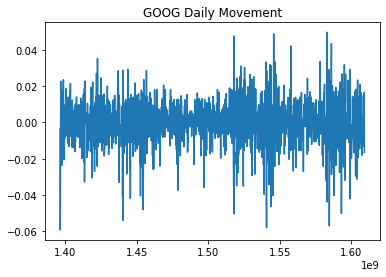

In [5]:
plt.title('GOOG Daily Movement')
plt.plot(df['timestamp'], df['log_change'])

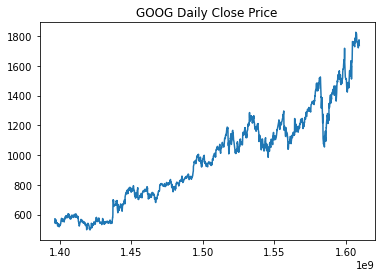

In [6]:
plt.title('GOOG Daily Close Price')
plt.plot(df['timestamp'], df['close'])

<AxesSubplot:title={'center':'GOOG Daily Movement Distribution'}, ylabel='Frequency'>

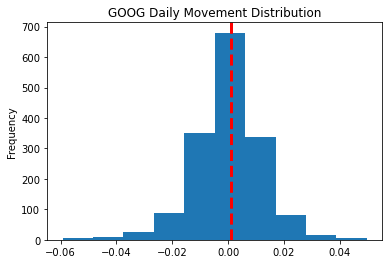

In [7]:
#plot distroduction of change
#draw line showing positve target and negative target
plt.title('GOOG Daily Movement Distribution')
plt.axvline(0.001, color='r', linestyle='dashed', linewidth=3)
#plt.axvline(-0.005, color='r', linestyle='dashed', linewidth=3)
df['log_change'].plot.hist()

In [8]:
#define target features
#target = positive change > 0.001 in a day
#negative target = negative change > 0.001 in a day

df['neg_target'] = [1 if change < 0.001 else 0 for change in df['log_change']]

df['pos_target'] = [1 if change > 0.001 else 0 for change in df['log_change']]

df.head()

,volume,timestamp,high,low,close,open,date,log_change,neg_target,pos_target
0,4018300,1.396544e+09,588.3000,566.010,571.50,573.39,03-04-2014 17:00:00,-0.003302,1,0
1,5363700,1.396631e+09,579.7173,544.494,545.25,578.55,04-04-2014 17:00:00,-0.059281,1,0
2,3961600,1.396890e+09,549.8500,530.530,540.63,544.79,07-04-2014 17:00:00,-0.007665,1,0
3,3482500,1.396976e+09,559.8800,544.700,557.51,545.05,08-04-2014 17:00:00,0.022603,0,1
4,3031600,1.397063e+09,567.8000,555.380,567.04,565.84,09-04-2014 17:00:00,0.002118,0,1


<AxesSubplot:title={'center':'Target Distro'}, ylabel='Frequency'>

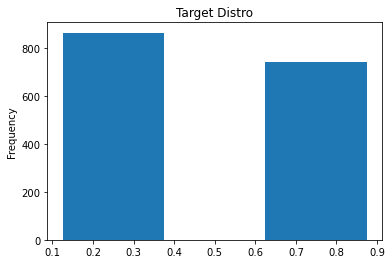

In [9]:
#plot postive change target frequency
plt.title('Target Distro')
df['pos_target'].plot.hist(bins=2, rwidth=0.5)

In [10]:
#grab wall street journel twitter feed data
#filter for tweet containing terms relating to Google
text_filter = {'name' : 'google', 'match_ngrams': ['google', 'alphabet', 'goog', 
                                                   'tech giant', 'pichai',
                                                   'deepmind']}

token = '6043b997951629542f20935fu84Bn1L3NtYVPObP4EIv7Ua0Ch8E2y'

# We need to pass the 'id_dataset', the name of the
# column (which is 'text') and an optional filter.
blend_source = {
                'id_dataset':'5e2ef74e9516294390e810a9',
                'feature' : 'text',
                'filter_text' : text_filter
            }

df_blend = OpenBlender.timeBlend( token = token, #blend tweet data within a day of each price datapoint
                                  anchor_ts = df.timestamp, #uses current data timestamp to find news data in that range
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,#get news data within a day of price timestamps
                                  direction = 'time_prior', #direction = 'time_prior',
                                  interval_output = 'list') #output list of news if more than one article
                                 

df_blend
df_news = pd.concat([df, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)

Task ID: '606cacbe0895fafb4a9d8d4c'.
Total estimated consumption: 5929.6 processing units.
Task confirmed. Starting download..
62.0%
100%


In [12]:
#take only prices with news data
df_valid_prices = pd.DataFrame()
df_valid_prices = df_news[df_news['WALL_STREE.text_COUNT_last1days:google'] > 0]
print(len(df_valid_prices))

478


In [ ]:
#save collected data to csv
df_news.to_csv("GOOG_PRICE_NEWS_ENRICHED.csv", index=False)